In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from extractors import ResNet50Extractor
from extractors import CIELABKMeansExctractor
from extractors import CIELABPositionalExctractor
from extractors import W2VVExtractor

print(tf.__version__)

2.6.1


In [2]:
images_paths = []
with open("v3c1/frame-ID-to-filepath.V3C1.csv") as file:
    images_paths = file.readlines()
    images_paths = ["v3c1/thumbs/" + line.rstrip() for line in images_paths]
images_paths[:3]

['v3c1/thumbs/00000/v00000_s00000(f00000000-f00000012)_f00000006.jpg',
 'v3c1/thumbs/00000/v00000_s00001(f00000018-f00000199)_f00000019.jpg',
 'v3c1/thumbs/00000/v00000_s00001(f00000018-f00000199)_f00000038.jpg']

In [18]:
extractor = CIELABPositionalExctractor(regions=(4,8), aggType="medoid-approx")
#extractor = W2VVExtractor(use_gpu=False, batch_size=8)
#extractor = ResNet50Extractor()

In [19]:
def l2_dist(a, b):
    return np.linalg.norm(a - b)
    
def cos_dist(a, b):
    a = a / np.linalg.norm(a, axis=-1)
    b = b / np.linalg.norm(b, axis=-1)
    return 1 - np.dot(a,b)

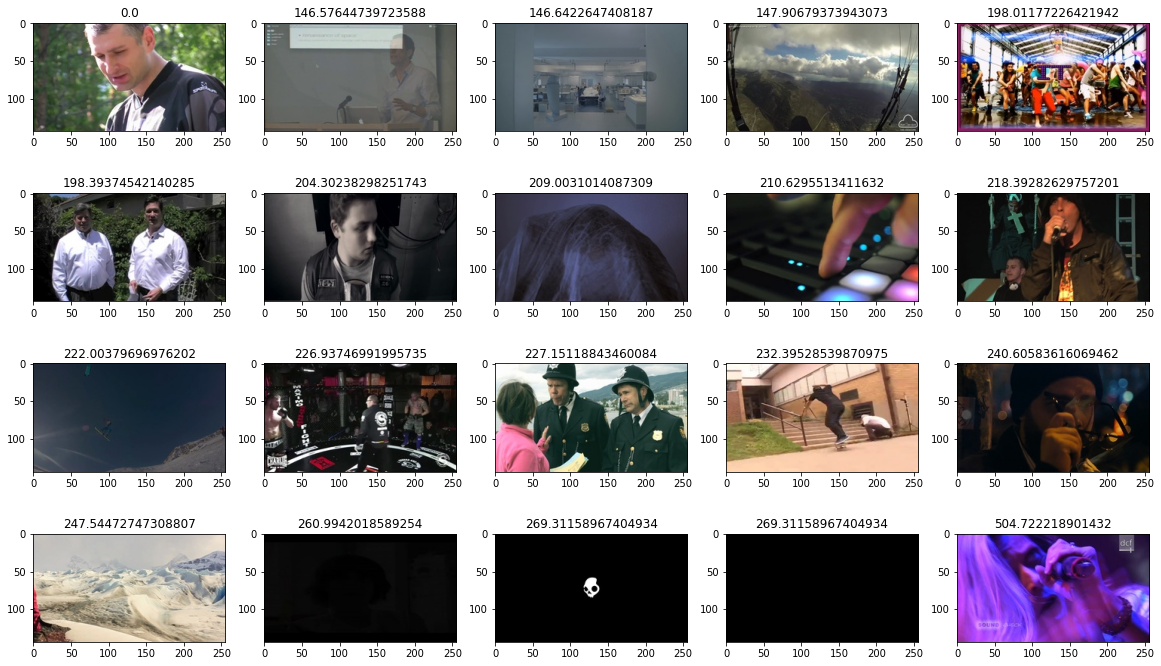

In [20]:
np.random.seed(42)
image_ids = np.random.randint(0, high=len(images_paths), size=(20,))

image_features = extractor([images_paths[img_id] for img_id in image_ids])

fig, axes = plt.subplots(ncols=5, nrows=image_ids.shape[0] // 5, figsize=(20,image_features.shape[0] * 6 // 10))

for ax, (img_id, idx) in zip([item for sublist in axes for item in sublist], sorted(zip(image_ids, range(image_ids.shape[0])), 
                              key=lambda tup: l2_dist(image_features[0], image_features[tup[1]]))):
    ax.set_title(l2_dist(image_features[0], image_features[idx]))
    ax.imshow(mpimg.imread(images_paths[img_id]))

plt.show()

In [6]:
from sklearn.cluster import KMeans
from skimage import io
from skimage import color

In [7]:
rgb = io.imread(images_paths[123])
lab = color.rgb2lab(rgb)
lab.reshape((-1, 3))

array([[44.75009587, 13.94751229, -4.10293804],
       [45.95567059, 13.88100861, -4.09446784],
       [47.35634379, 14.76284903, -5.57371618],
       ...,
       [36.09781474, -2.67781893,  3.66167724],
       [36.93862539, -2.66766227,  3.64686286],
       [36.09781474, -2.67781893,  3.66167724]])

In [21]:
kmeans = KMeans(n_clusters=8).fit(lab.reshape((-1, 3)))

In [24]:
feats = kmeans.cluster_centers_
display(feats)
scores = np.linalg.norm(feats, axis=1)
print(scores)
display(feats[np.argsort(scores)])

array([[16.91125222, 16.66808738, -7.06638624],
       [50.05395376,  0.95812776,  3.56173627],
       [65.20708311,  3.076127  ,  0.07795188],
       [31.75560781, 12.76363841, -2.76510425],
       [35.8309685 ,  0.24430186,  3.85596332],
       [50.76899045,  8.88801186, -7.85508716],
       [40.19995262, 20.36615108,  4.09140188],
       [24.13501346, 15.1082221 , -4.81291337]])

[24.77396624 50.18966289 65.27964707 34.33620385 36.03867978 52.13625937
 45.24992674 28.87769701]


array([[16.91125222, 16.66808738, -7.06638624],
       [24.13501346, 15.1082221 , -4.81291337],
       [31.75560781, 12.76363841, -2.76510425],
       [35.8309685 ,  0.24430186,  3.85596332],
       [40.19995262, 20.36615108,  4.09140188],
       [50.05395376,  0.95812776,  3.56173627],
       [50.76899045,  8.88801186, -7.85508716],
       [65.20708311,  3.076127  ,  0.07795188]])

In [28]:
lab.shape

(144, 256, 3)

In [8]:
arr = lab[:36,:64].reshape((-1,3))
dist_mat = np.linalg.norm(arr.reshape((-1,1,3)) - arr.reshape((1,-1,3)), axis=-1)
dist_mat.shape

(2304, 2304)

In [10]:
np.sum(np.linalg.norm(arr.reshape((-1,1,3)) - arr[:100].reshape((1,-1,3)), axis=-1), axis=1).shape

(2304,)